In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi, c
from scipy import signal

# Radar Model - MIMO

In [2]:
10*np.tan(np.deg2rad(30))

np.float64(5.773502691896257)

In [3]:
# Single Target

#target_location = np.array([10, 10*np.tan(np.deg2rad(90-30))]) # Target location on 2-dimensional plane [m]
target_location = np.array([20, 20])
target_velocity = np.array([1, 1]) # Target velocity in m/s in each dimension [m/s]

In [4]:
# MIMO radar setup

""" TRANSMITTER TXs"""

f_c = 77e9          # start frequency - [Hz]
wavelength = c/f_c  # Lambda wakelength at carrier frequency - [m]

T_c = 25.66e-6      # chirp time/ duration - [s]
bw = 0.77*1e9           # bandwidth eg. from 76. GHz to 77.5 GHz - [Hz]
S = bw/T_c          # chirp rate - [Hz/s]
prf = 1/T_c         # pulse repetition frequency - [Hz]

M = 128             # number of chirps

TX_locations = np.array(([-4*(wavelength/2), 0],
                        [0, 0])) # remeber to set 1 TX like this : np.array([[0, 0]]) ensure shape (1,2)
                        #[-3*wavelength, 0]))    # Transmitter location on 2-dimensional plane [m]

                                    # TI har 3 transmitter
                                    # Unilateral antenna array: 1 lambda spacing between antennas


""" RECEIVER RXs"""

fs = 20e6           # sampling frequency - [Hz]
Ns = 128          # number of samples (ADC) - [samples]

RX_locations = np.array(([5*(wavelength/2), 0],
                        [6*(wavelength/2), 0],
                        [7*(wavelength/2), 0],
                        [8*(wavelength/2), 0]))  # Receiver location on 2-dimensional plane [m]
    
                                    # TI har 4 receiver
                                    # Unilateral antenna array: 1/2 lambda spacing between antennas

""" Path loss """

gain = 1            # gain of the antenna - [dB]
transmit_power = 1  # transmit power - [W]
rcs = 1             # radar cross section - [m^2]

""" SNR """

SNR = 10            # signal to noise ratio - [dB]



In [5]:
print(f"wavelength: {wavelength} m \n chirp_rate: {S} Hz/s \n prf: {prf} Hz \n TX_locations: {TX_locations} m \n RX_locations: {RX_locations} m")

print(f"range resolution: {c/(2*bw)}")

wavelength: 0.0038934085454545454 m 
 chirp_rate: 30007794232268.12 Hz/s 
 prf: 38971.16134060795 Hz 
 TX_locations: [[-0.00778682  0.        ]
 [ 0.          0.        ]] m 
 RX_locations: [[0.00973352 0.        ]
 [0.01168023 0.        ]
 [0.01362693 0.        ]
 [0.01557363 0.        ]] m
range resolution: 0.19467042727272726


In [6]:
"""Compute all radial distances from the target to the TXs and RXs"""
r_TX = np.linalg.norm(TX_locations - target_location, axis=1)
r_RX = np.linalg.norm(RX_locations - target_location, axis=1)

r_TX, r_RX

(array([28.28977789, 28.28427125]),
 array([28.27738945, 28.27601329, 28.27463719, 28.27326117]))

In [7]:
"""Compute all radial velocities from the target to the TXs and RXs"""

def compute_radial_velocity(x_target, y_target, x_target_velocity, y_target_velocity, x_base, y_base):
    dx = x_target - x_base
    dy = y_target - y_base
    distance = np.sqrt(dx**2 + dy**2)
    radial_velocity = (dx * x_target_velocity + dy * y_target_velocity) / distance
    return radial_velocity

v_TX = compute_radial_velocity(target_location[0], target_location[1], target_velocity[0], target_velocity[1], TX_locations[0][0], TX_locations[0][1])
v_RX = compute_radial_velocity(target_location[0], target_location[1], target_velocity[0], target_velocity[1], RX_locations[:,0], RX_locations[:,1])

v_TX, v_RX


(np.float64(1.4142135355866006),
 array([1.41421352, 1.4142135 , 1.41421348, 1.41421346]))

In [8]:
""" Compute intermediate frequency (IF) signal frequency for TX-RX pair """

def compute_IF(r_TX, r_RX):
    IF_signal = (S*(r_TX+r_RX))/ c
    return IF_signal

""" Compute the phase shift of the IF signal """

def compute_phase_shift():
    phase_shift = 2*pi*f_c*(2*(v_RX[0]*T_c)/c)
    return phase_shift

""" Compute the phase difference between the TX and RX antenna pairs"""

def compute_phase_diff(r_tx, r_rx):
    phase_diff = (2*pi*(r_tx + r_rx)) / wavelength % (2*pi)
    #phase_diff = (2*pi*r_rx*np.sin(np.deg2rad(45)))/wavelength % (2*pi)
    return phase_diff

In [9]:
# Compute the intermediate frequencies for all TX-RX pairs

IF_signals = np.zeros((len(TX_locations), len(RX_locations)))

for t in range(len(TX_locations)):
    for r in range(len(RX_locations)):
        IF_signals[t, r] = compute_IF(r_TX[t], r_RX[r]) # add index to r_TX for multiple transmitters 

# Compute the phase shift of the IF signal

phase_diff = compute_phase_shift() # rad

# Comput the phase difference between the TX and RX antenna pairs

phase_diff_antennas = np.zeros((len(TX_locations), len(RX_locations)))

for t in range(len(TX_locations)):
    for r in range(len(RX_locations)):
        phase_diff_antennas[t, r] = compute_phase_diff(r_TX[t], r_RX[r]) # # add index to r_TX for multiple transmitters 
        

print(IF_signals)
print(phase_diff)
print(phase_diff_antennas)

[[5662103.47379122 5661965.72682466 5661827.98656958 5661690.25302698]
 [5661552.28470768 5661414.53774112 5661276.79748604 5661139.06394344]]
0.11712551763857859
[[6.01623631 3.7953897  1.5746513  5.63720642]
 [3.41279102 1.1919444  5.25439131 3.03376112]]


In [10]:
""" Create all frames for all TX-RX pair IF signals """

times = np.linspace(0, Ns/fs, Ns)

IF_signals_data = {}

for t in range(len(TX_locations)):
    for r in range(len(RX_locations)):
        window = signal.windows.blackman(Ns)
        chirp = np.array(
            [
                (
                    (np.sqrt((transmit_power*gain*(wavelength**2)*rcs)/(((4*pi)**3)*((r_RX[r])**4))))
                    * np.exp(1j * (2 * pi * IF_signals[t, r] * times + m * phase_diff + phase_diff_antennas[t, r])) 
                    #+ np.random.normal(0, 0.00000005, Ns) + 1j*np.random.normal(0, 0.00000005, Ns) # Add noise
                )
                * window
                for m in range(M)
            ]
        )
        IF_signals_data[(t, r)] = chirp # Dette er jo egentlig bare en frame

In [31]:
def add_noise(signal, snr_db):
    snr_linear = 10 ** (snr_db / 20)  # Convert SNR from dB to linear scale
    signal_power = np.mean(np.abs(signal) ** 2)  # Compute signal power
    noise_power = signal_power / snr_linear  # Compute noise power
    noise = np.sqrt(noise_power) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape)) / np.sqrt(2)
    return signal + noise

In [41]:
for idx, (key, chirp) in enumerate(IF_signals_data.items()):
        IF_signals_data[key][idx] = add_noise(chirp[idx], -10)

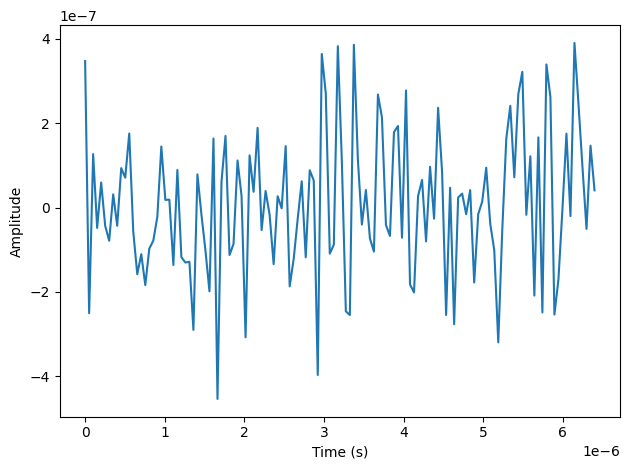

In [42]:
plt.plot(times, IF_signals_data[0,0][0])

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


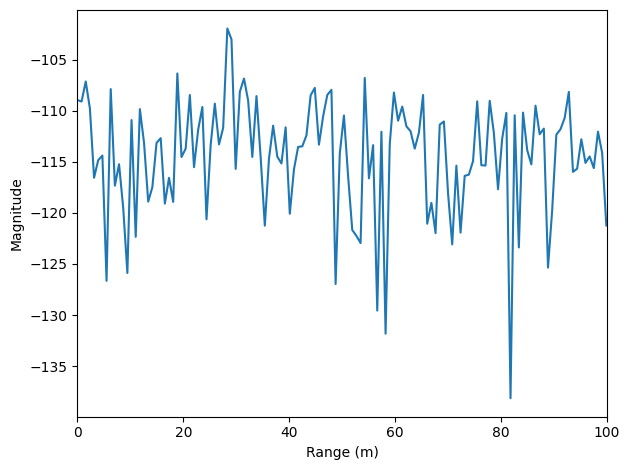

-101.92359114900185


In [43]:
"""Range FFT """

max_range = (20e6*c)/(2*S)
max_vel = wavelength / (4 * T_c) # m/s

ranges = np.linspace(0, max_range, Ns)

X_k = np.fft.fft(IF_signals_data[0,0][0])
X_k = np.abs(X_k)
X_k = 20 * np.log10(X_k)

plt.plot(ranges, X_k)
plt.xlabel("Range (m)")

plt.ylabel("Magnitude")
plt.xlim([0, 100])

plt.tight_layout()
plt.show()

print(np.max(X_k))


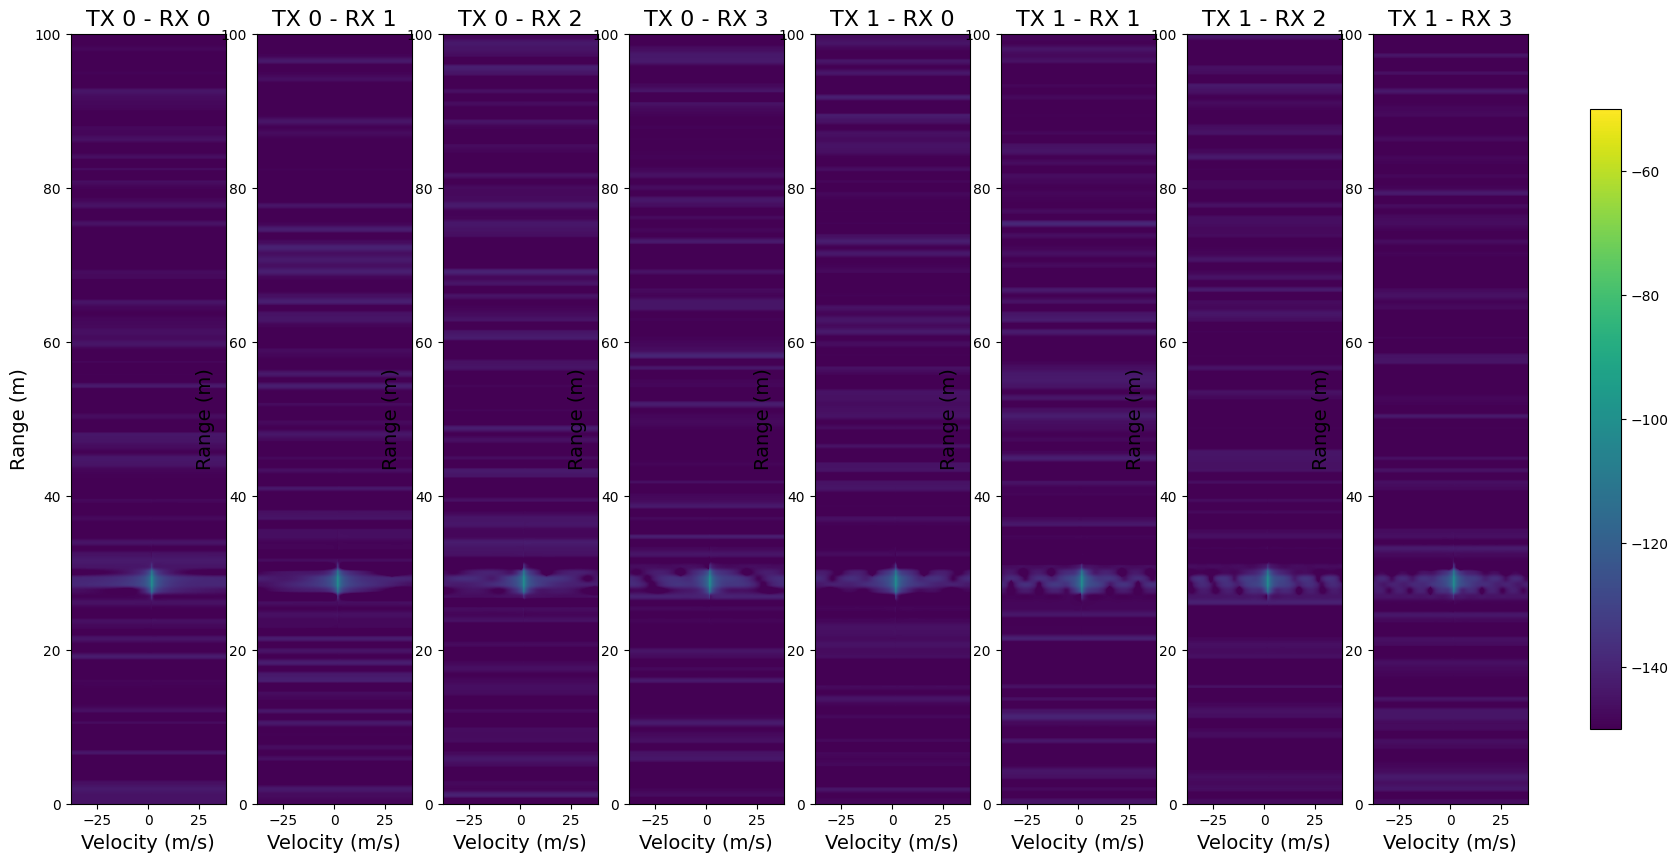

In [44]:
fig, axs = plt.subplots(1, len(IF_signals_data), figsize=(20, 10))

range_doppler_rxs = {}

for idx, (key, chirp) in enumerate(IF_signals_data.items()):
    range_doppler = np.fft.fftshift(np.fft.fft2(chirp.T), axes=1) / (Ns / 2)
    range_doppler_rxs[idx] = range_doppler

    extent = [-max_vel, max_vel, ranges.min(), ranges.max()]

    range_doppler_plot = axs[idx].imshow(
        20 * np.log10(np.abs(range_doppler)),  # np.abs(...): Takes the magnitude, removing the phase.
        aspect="auto",
        extent=extent,
        origin="lower",
        vmax=-50,
        vmin=-150,
    )
    axs[idx].set_ylim([0, 100])
    axs[idx].set_xlabel("Velocity (m/s)", fontsize=14)
    axs[idx].set_ylabel("Range (m)", fontsize=14)
    axs[idx].set_title(f"TX {key[0]} - RX {key[1]}", fontsize=16)

fig.colorbar(range_doppler_plot, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()


In [16]:
def extract_phasor(fft_2d):
    """
    Extracts the complex phasor from the 2D FFT peak location.

    Parameters:
    fft_2d : np.array
        2D FFT output.

    Returns:
    phasor : complex
        Complex phasor at the peak location.
    """

    # Find peak location in FFT
    peak_index = np.unravel_index(np.argmax(np.abs(fft_2d)), fft_2d.shape)
    print(peak_index)

    # Extract phasor at the peak position
    phasor = fft_2d[peak_index]

    return phasor


phasors = np.array([extract_phasor(range_doppler_rxs[i]) for i in range(len(range_doppler_rxs))])

phasors


(np.int64(37), np.int64(66))
(np.int64(37), np.int64(66))
(np.int64(37), np.int64(66))
(np.int64(37), np.int64(66))
(np.int64(37), np.int64(66))
(np.int64(37), np.int64(66))
(np.int64(37), np.int64(66))
(np.int64(37), np.int64(66))


array([ 6.84987048e-06-4.20952728e-06j, -7.50228566e-06-2.88342496e-06j,
        2.26500580e-06+7.70880585e-06j,  4.74768439e-06-6.47864699e-06j,
       -8.02392823e-06+1.92434043e-07j,  5.02516410e-06+6.25503716e-06j,
        1.91661714e-06-7.78855428e-06j, -7.34948130e-06+3.20582050e-06j])

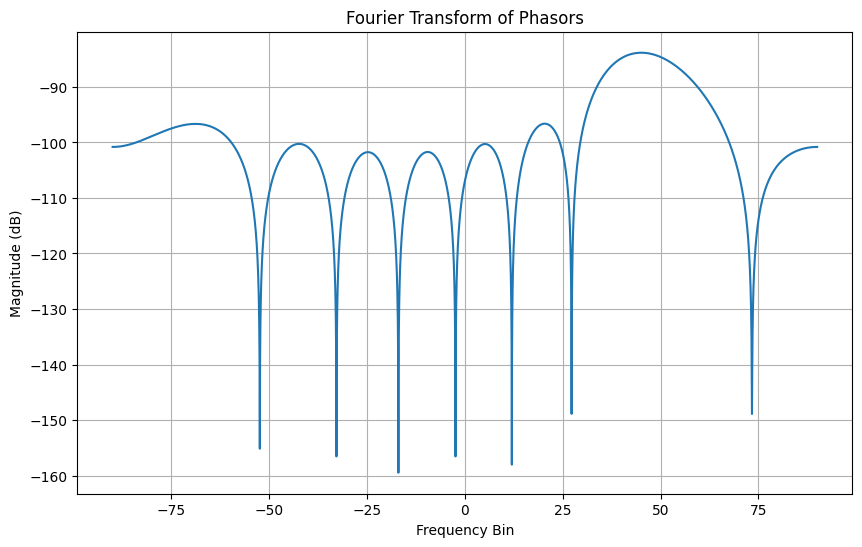

np.float64(45.07144837773933)

In [17]:
# Perform Fourier transform on the phasors

# Zero pad fourier transform
phasors_zero_padded = np.pad(phasors, (0, 1000001-len(phasors)), mode='constant')
phasors_fft = np.fft.fftshift(np.fft.fft(phasors_zero_padded))
phasors_fft_magnitude = np.abs(phasors_fft)
phasors_fft_db = 20 * np.log10(np.abs(phasors_fft_magnitude))

anglebins = np.arcsin(np.linspace(1, -1, 1000001))*180/pi

#angle_fft_x = np.linspace(-90, 90, 200)

# Plot the Fourier transform of the phasors
plt.figure(figsize=(10, 6))
plt.plot(anglebins, phasors_fft_db)
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude (dB)')
plt.title('Fourier Transform of Phasors')
plt.grid(True)
plt.show()

anglebins[np.argmax(phasors_fft_db)]

# Bartlett angle

In [18]:
def extract_phasor_for_covariance_matrix(fft_2d):
    """
    Extracts the complex phasor from the 2D FFT peak location.

    Parameters:
    fft_2d : np.array
        2D FFT output.

    Returns:
    phasor : complex
        Complex phasor at the peak location.
    """

    # Find peak location in FFT
    peak_index = np.unravel_index(np.argmax(np.abs(fft_2d)), fft_2d.shape)

    # Extract phasor at the peak position and two phasors above and below
    phasors = []
    for i in range(-2, 3):
        idx = (peak_index[0] + i) % fft_2d.shape[0]
        phasors.append(fft_2d[idx, peak_index[1]])
    return phasors


phasors = np.array([extract_phasor_for_covariance_matrix(range_doppler_rxs[i]) for i in range(len(range_doppler_rxs))])

phasors


array([[ 2.14632953e-06-1.46879380e-06j, -6.59187383e-06+4.27732749e-06j,
         6.84987048e-06-4.20952728e-06j, -2.43455908e-06+1.41502441e-06j,
         1.38974922e-07-7.62756113e-08j],
       [-2.47466363e-06-8.14166046e-07j,  7.40606837e-06+2.63973021e-06j,
        -7.50228566e-06-2.88342496e-06j,  2.59918733e-06+1.07289972e-06j,
        -1.44401783e-07-6.37979112e-08j],
       [ 8.57599891e-07+2.46457857e-06j, -2.40226756e-06-7.49111489e-06j,
         2.26500580e-06+7.70880585e-06j, -7.25212075e-07-2.71265882e-06j,
         3.68626228e-08+1.52822537e-07j],
       [ 1.43974868e-06-2.18165199e-06j, -4.49546774e-06+6.46127718e-06j,
         4.74768439e-06-6.47864699e-06j, -1.71239614e-06+2.22030561e-06j,
         9.86176922e-08-1.21577698e-07j],
       [-2.61028610e-06+1.91061485e-07j,  7.86339388e-06-3.81844315e-07j,
        -8.02392823e-06+1.92434043e-07j,  2.79885035e-06+1.58349511e-09j,
        -1.55776977e-07-3.91229822e-09j],
       [ 1.74024638e-06+1.96076508e-06j, -5.082628

In [19]:
R = phasors @ phasors.conj().T*(1/5) # Covariance matrix

In [20]:
def doa_bartlett(R, d = 0.5, scan_angles = range(-90, 91)):
    """ bartlett beamforming implementation """
    n_array = np.shape(R)[0]
    array = np.linspace(0, (n_array - 1) * d, n_array)
    scan_angles = np.linspace(-90, 90, 100001)

    array_grid, angle_grid = np.meshgrid(array, np.radians(scan_angles), indexing = "ij")
    steering_vec = np.exp(-1.j * 2 * np.pi * array_grid * np.sin(angle_grid))

    ps = np.sum(steering_vec.conj() * (R @ steering_vec), axis = 0).real

    # real and np.abs() provides aprrox the same result (complex part is very small)
    return 10 * np.log10(ps)

np.float64(45.072)

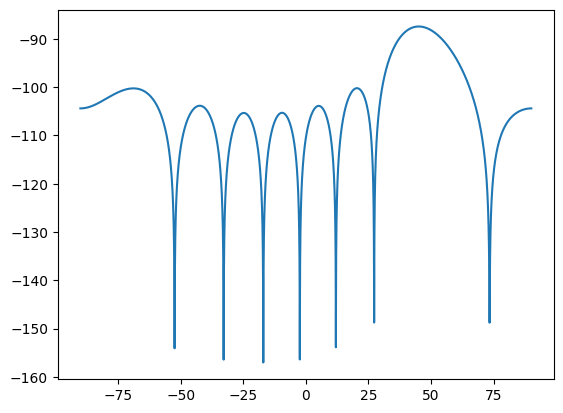

In [21]:
barlett_angle = doa_bartlett(R)

anglebins = np.linspace(-90, 90, 100001)

plt.plot(anglebins, barlett_angle)

anglebins[np.argmax(barlett_angle)]

# MUSIC angle

In [22]:
def doa_music(R, n_sig, d = 0.5, scan_angles = range(-90, 91)):
    """ MUSIC algorithm implementation """
    n_array = np.shape(R)[0]
    array = np.linspace(0, (n_array - 1) * d, n_array)
    scan_angles = np.array(scan_angles)

    # 'eigh' guarantees the eigen values are sorted
    _, e_vecs = np.linalg.eigh(R)
    noise_subspace = e_vecs[:, :-n_sig]

    array_grid, angle_grid = np.meshgrid(array, np.radians(scan_angles), indexing = "ij")
    steering_vec = np.exp(-1.j * 2 * np.pi * array_grid * np.sin(angle_grid)) 
    
    # 2-norm (frobenius)
    ps = 1 / np.square(np.linalg.norm(steering_vec.conj().T @ noise_subspace, axis = 1))

    return 10 * np.log10(ps)

np.float64(45.072)

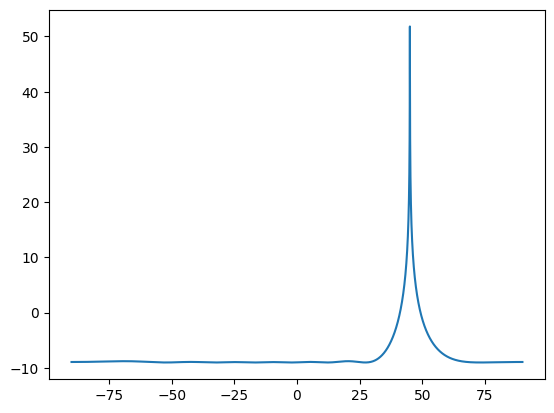

In [23]:
barlett_angle = doa_music(R, 1, scan_angles = np.linspace(-90, 90, 100001))

anglebins = np.linspace(-90, 90, 100001)

plt.plot(anglebins, barlett_angle)

anglebins[np.argmax(barlett_angle)]